In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_image
from tensorflow import keras
from tensorflow.keras import layers

# 1. Load Fashion Mnist data

In [16]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data() 
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:] # X_train : (55000, 28, 28), X_valid : (5000, 28, 28)
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:] # y_train : (55000,), y_valid : (5000, )

X_test_org = X_test[:] # X_test 복사 (10000, 28, 28)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, X_test.shape, y_test.shape, X_test_org.shape

((55000, 28, 28),
 (5000, 28, 28),
 (55000,),
 (5000,),
 (10000, 28, 28),
 (10000,),
 (10000, 28, 28))

# 2. Data Standardization (input - mean) / std

In [17]:
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7 # std + epsilon

X_mean.shape, X_std.shape # (1, 28, 28)

((1, 28, 28), (1, 28, 28))

In [18]:
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train.shape, X_valid.shape, X_test.shape # (55000, 28, 28), (5000, 28, 28), (10000, 28, 28)

((55000, 28, 28), (5000, 28, 28), (10000, 28, 28))

# 3. Dimension 늘리기(4차원으로 맞추기) - np.newaxis

In [19]:
# conv mini-batch 입력은 항상 4차원 (mini-batch size, h, w, d) 현재 d는 1(흑백)
X_train = X_train[..., np.newaxis] # ... : 원래꺼 가져오기, np.newaxis : 마지막에 차원 하나 추가
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

X_train.shape, X_valid.shape, X_test.shape # (55000, 28, 28, 1), (5000, 28, 28, 1), (10000, 28, 28, 1)
# 한번만 실행해야함(아님 계속 dimension이 추가된다...)

((55000, 28, 28, 1), (5000, 28, 28, 1), (10000, 28, 28, 1))

# 4. Test 이미지 확인

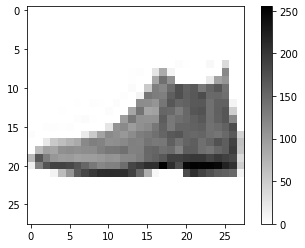

In [20]:
# original test image
plt.imshow(X_test_org[0][:, :], cmap='binary') # plt.imshow(X_test_org[0, :, :], cmap='binary')
plt.colorbar() # 이미지 출력할 때 colorbar도 함께 표시
plt.show()

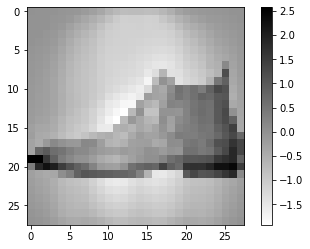

In [21]:
# Standardization를 거친 test image
plt.imshow(X_test[0][:, :, 0], cmap='binary') # plt.imshow(X_test[0, :, :, 0], cmap='binary')
plt.colorbar()
plt.show()

# 5. Model 만들기

In [56]:
from functools import partial

# 내가 만드는 conv2d
DefaultConv2D = partial(
    keras.layers.Conv2D,
    kernel_size=3, # default kernel size는 3
    activation='relu', padding='SAME'
)

model = keras.models.Sequential([
  DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1], name='conv1'),
  keras.layers.MaxPooling2D(pool_size=2, name='pool1'),
  DefaultConv2D(filters=128, name='conv2'), # kernel size = 3
  DefaultConv2D(filters=128, name='conv3'),
  keras.layers.MaxPool2D(pool_size=2, name='pool2'),
  DefaultConv2D(filters=256, name='conv4'),
  DefaultConv2D(filters=256, name='conv5'),
  keras.layers.MaxPooling2D(pool_size=2, name='pool3'),
  keras.layers.Flatten(name='fltn1'),
  keras.layers.Dense(units=128, activation='relu', name='dens1'),
  keras.layers.Dropout(0.5, name='drop1'),
  keras.layers.Dense(units=64, activation='relu', name='dens2'),
  keras.layers.Dropout(0.5, name='drop2'),
  keras.layers.Dense(units=10, activation='softmax', name='dens3')
])

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 64)        3200      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 128)       73856     
_________________________________________________________________
conv3 (Conv2D)               (None, 14, 14, 128)       147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv4 (Conv2D)               (None, 7, 7, 256)         295168    
_________________________________________________________________
conv5 (Conv2D)               (None, 7, 7, 256)        

# 6. Model Compile, Fit

In [58]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 36s 20ms/step - loss: 0.6930 - accuracy: 0.7602 - val_loss: 0.4060 - val_accuracy: 0.8498
Epoch 2/10
1719/1719 [==============================] - 35s 20ms/step - loss: 0.4183 - accuracy: 0.8600 - val_loss: 0.3303 - val_accuracy: 0.8804
Epoch 3/10
1719/1719 [==============================] - 34s 20ms/step - loss: 0.3645 - accuracy: 0.8781 - val_loss: 0.2896 - val_accuracy: 0.8930
Epoch 4/10
1719/1719 [==============================] - 34s 20ms/step - loss: 0.3272 - accuracy: 0.8897 - val_loss: 0.2903 - val_accuracy: 0.8948
Epoch 5/10
1719/1719 [==============================] - 34s 20ms/step - loss: 0.3075 - accuracy: 0.8951 - val_loss: 0.2983 - val_accuracy: 0.8968
Epoch 6/10
1719/1719 [==============================] - 34s 20ms/step - loss: 0.2901 - accuracy: 0.9007 - val_loss: 0.3157 - val_accuracy: 0.8998
Epoch 7/10
1719/1719 [==============================] - 34s 20ms/step - loss: 0.2860 - accuracy: 0.9014 - val_loss: 0.2961 -

# 7. Visualizing CNN Layer Outputs (activations)

In [59]:
layer_cnt = 8
layer_names = [layer.name for layer in model.layers[:layer_cnt]]

layer_outputs = [layer.output for layer in model.layers[:layer_cnt]]
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs) # 여기서의 inputs으로 들어가는 model은 이미 학습된 모델

img_tensor = X_test[:1] # 이 이미지에 대해서 filter를 살펴본다, [0]이 아닌 [:1]을 한 이유 : dimension 유지

activations = activation_model.predict(img_tensor) # 실제 이미지를 넣고, cnn visualize한 것을 activations에 저장한다
print(len(activations))
print(activations[0].shape) # (1, 28, 28, 64) => conv1 (Conv2D) (None, 28, 28, 64) 3200 이기 때문에(model.summary에서)    

8
(1, 28, 28, 64)


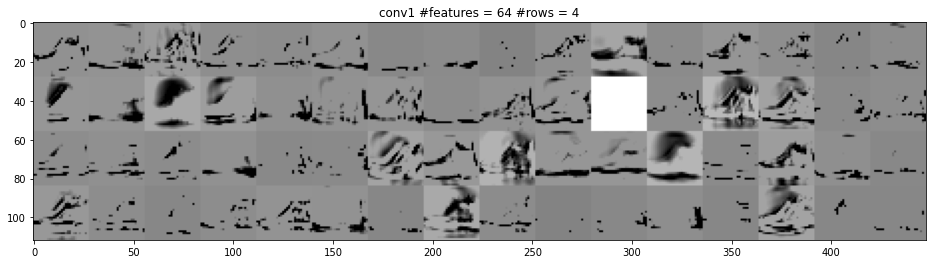

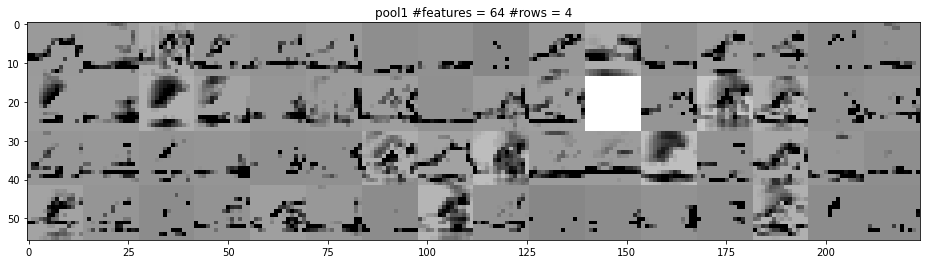

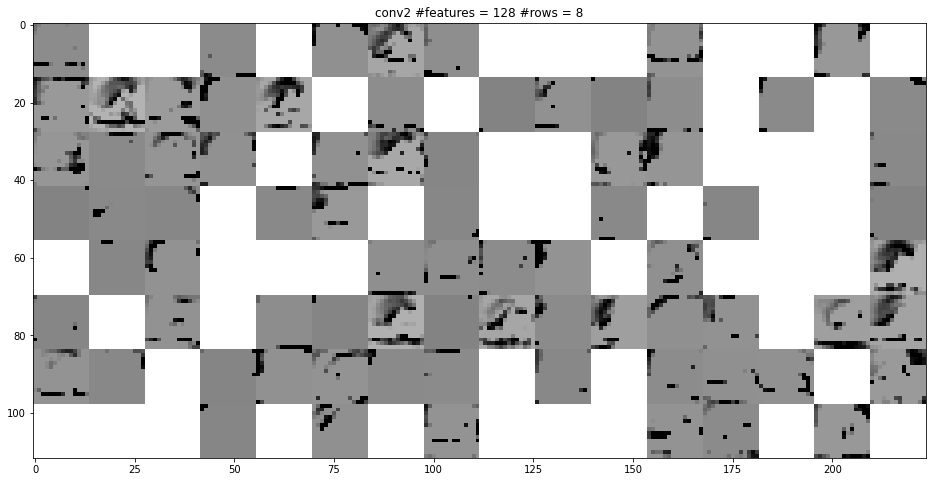

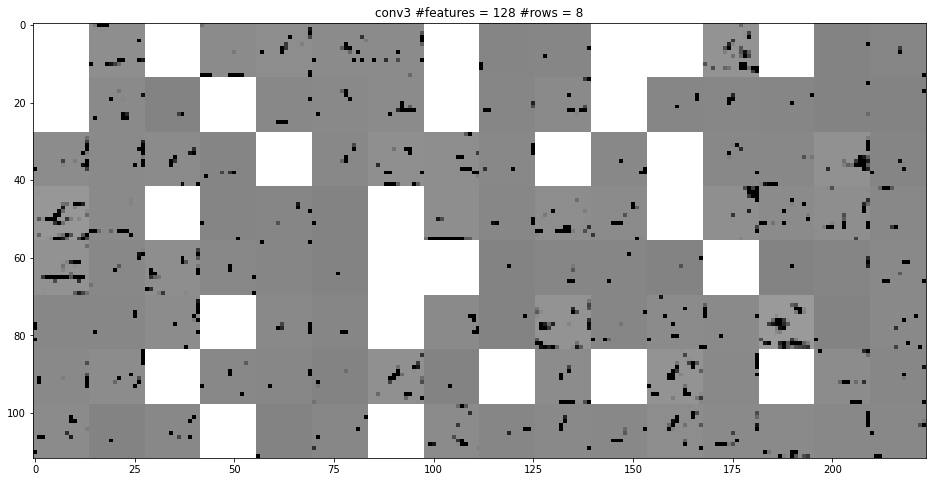

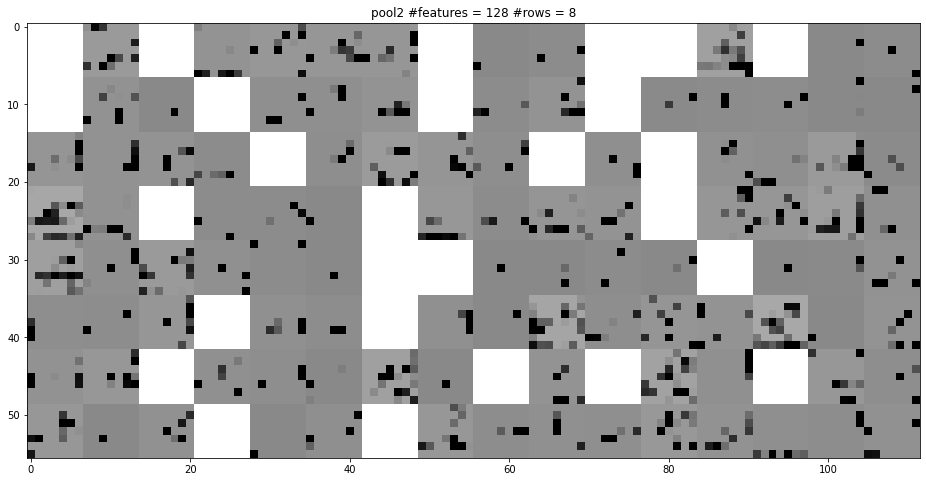

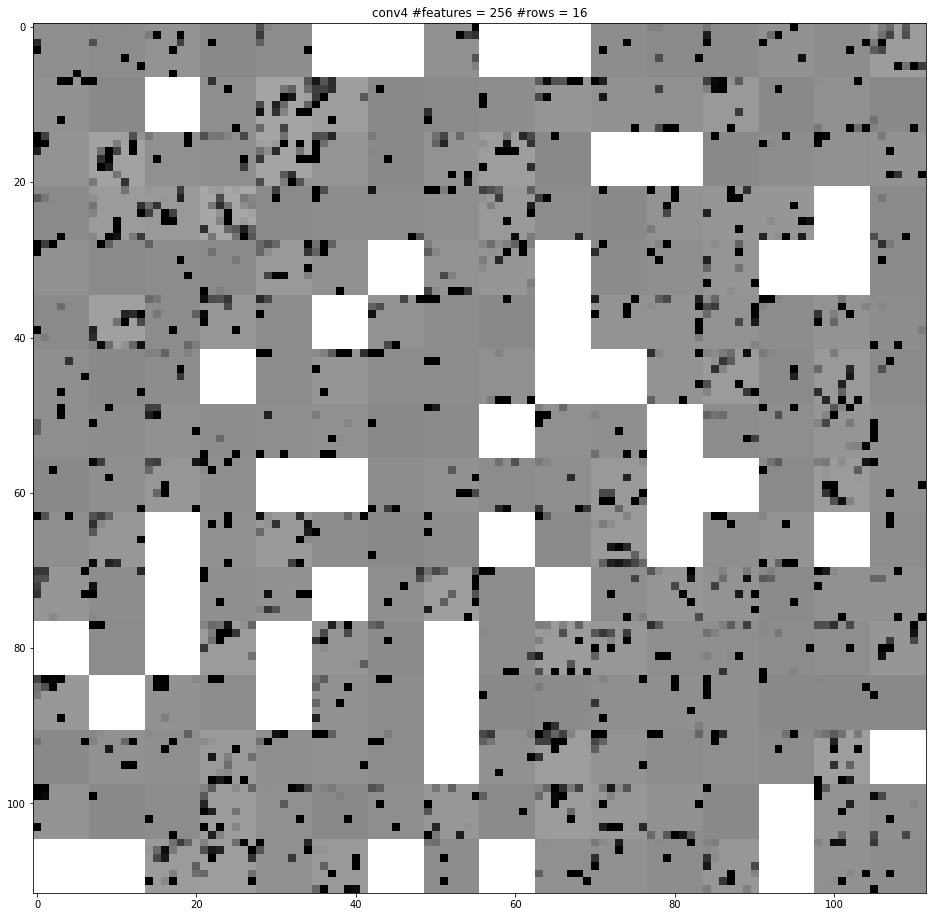

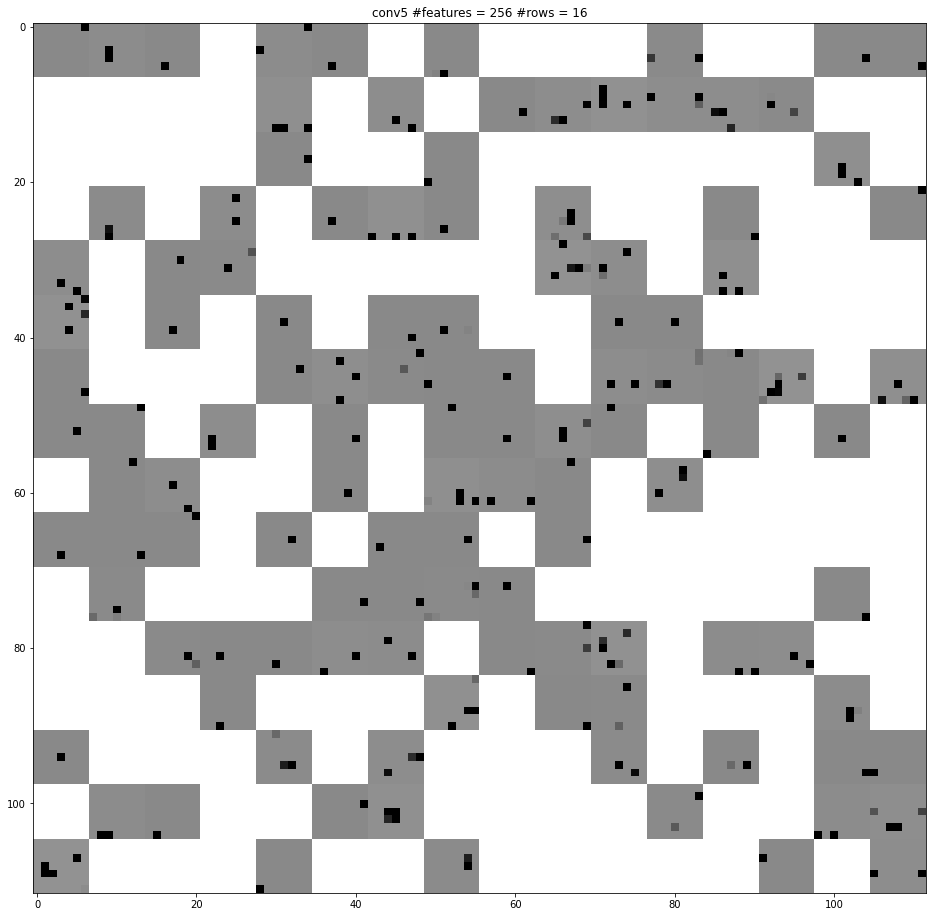

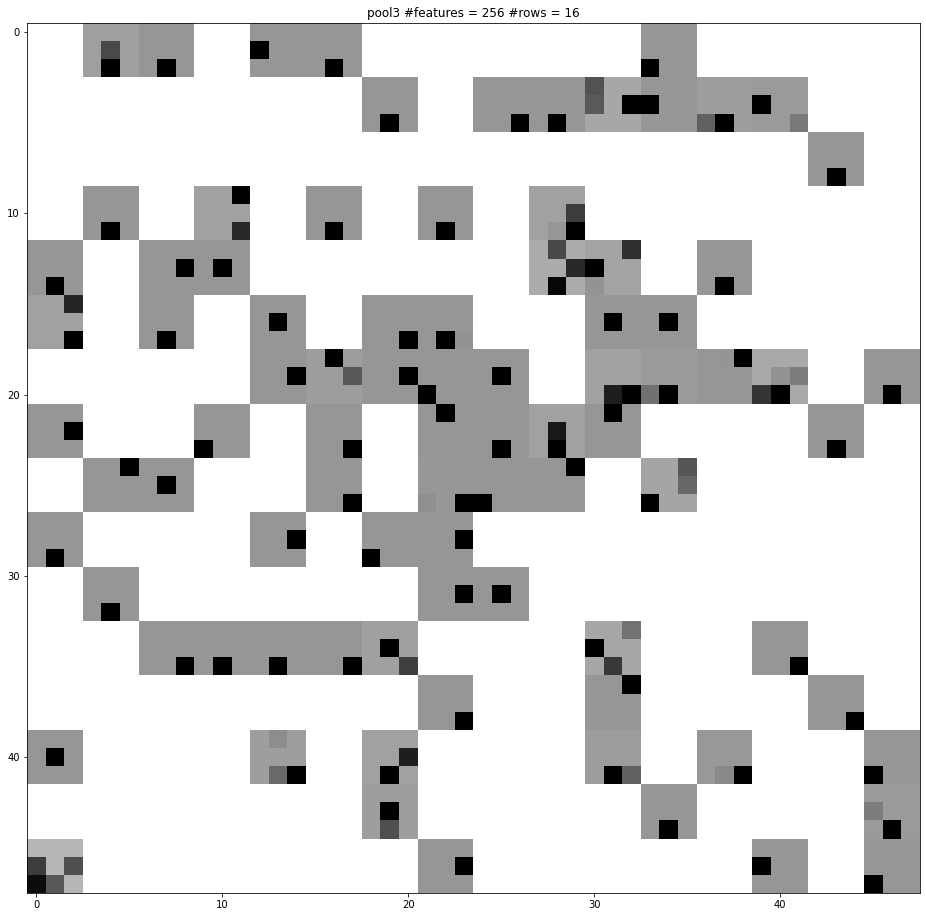

In [62]:
# Display activations (feature maps)
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations) : # layer_activation.shape : (1, 28, 28, 64) (mini-batch, h, w, filter)
  n_features = layer_activation.shape[-1] # layer_activation.shape[-1은 filter 갯수(feature 갯수)
  size = layer_activation.shape[1] # h == w (activation 한 변 길이)

  n_cols = n_features // images_per_row # 그림으로 출력할 때 activation이 얼마나 들어갈 수 있는지
  display_grid = np.zeros((size * n_cols, images_per_row * size))
  
  for col in range(n_cols) :
    for row in range(images_per_row) :
      channel_image = layer_activation[0, :, :, col * images_per_row + row]
      # Post processing - 이렇게 해야 image 가 잘 나오더라
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image # channel image를 display_grid 안에 잘 맞춰서 넣기

  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
  plt.title(layer_name + " #features = " + str(n_features) + " #rows = " + str(n_cols))
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='binary')
  plt.show()

# 8. Visualizing CNN Filters

In [78]:
def generate_pattern(layer_name, filter_index, size=28) :
  img_tensor = np.random.random((1, size, size, 1)) * 20 + 128 # random image (+noise)에 대해 filter의 변화를 봐야 잘 나온다
  img_tensor = tf.Variable(tf.cast(img_tensor, tf.float32)) # input의 tf 변수로 바꾼다

  conv_layer = model.get_layer(layer_name) # 해당 이름의 layer을 가져온다
  step_size = 1

  submodel = keras.models.Model([model.input[0]], [conv_layer.output]) # input과 해당 계층의 output과의 연관을 찾는다
  for _ in range(40) : # 학습하는게 아니라 gradient 뽑아내고 있는 것
    with tf.GradientTape() as tape :
      outputs = submodel(img_tensor)
      loss_value = tf.reduce_mean(outputs[:, :, :, filter_index])
    grads = tape.gradient(loss_value, img_tensor)
    normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.squre(grads))) + 1e-5)
  img = img_tensor[0].numpy.astype(np.uint8)
  return img

In [82]:
for k in range(5): 
    layer_name = 'conv'+str(k+1)

    column_cnt = 16 
    row_cnt = model.get_layer(layer_name).output.shape[-1] // column_cnt 
    margin = 1 
    
    results = np.zeros((row_cnt * size + (row_cnt-1) * margin, column_cnt * size + (column_cnt-1) * margin)).astype(np.uint8)

    
    for i in range(row_cnt):
        for j in range(column_cnt): 
            filter_img = generate_pattern(layer_name, i*column_cnt + j, size=size)
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end] = filter_img

    plt.figure(figsize=(20, 20))
    plt.title('filters of '+layer_name)
    plt.imshow(results, cmap='binary') 
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# 9. Visualizing Class Activation Map (Heatmap)

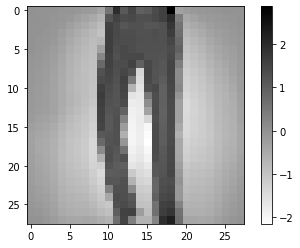

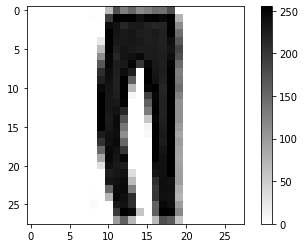

In [84]:
from keras.preprocessing import image

testImgIdx = 2

x = X_test[testImgIdx:testImgIdx+1] # dimension 유지하면서 image 가져오기 (정규화 한 image)
plt.imshow(x[0][:, :, 0], cmap='binary')
plt.colorbar()
plt.show()

plt.imshow(X_test_org[testImgIdx], cmap='binary') # 원본 이미지
plt.colorbar()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


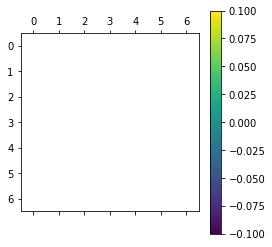

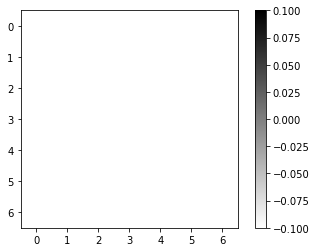

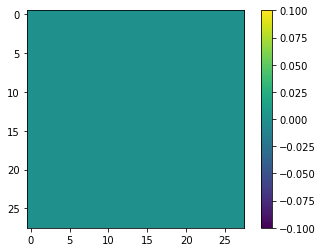

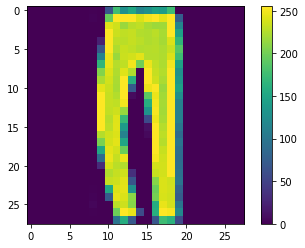

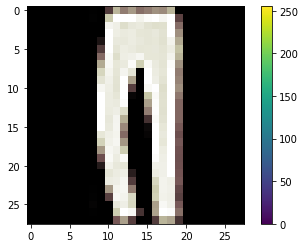

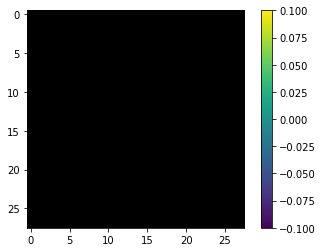

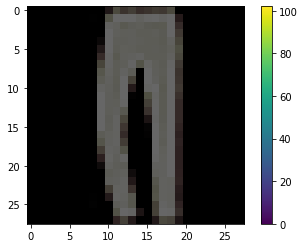

In [89]:
import cv2
TROUSER_IDX, ANKLE_BOOT_IDX, PULLOVER_IDX = 1, 9, 2
testImgIdx2TargetIdx = [ANKLE_BOOT_IDX, PULLOVER_IDX, TROUSER_IDX]
last_conv_layer = model.get_layer('conv5')

grad_model = keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(x)
    loss = predictions[:, testImgIdx2TargetIdx[testImgIdx]]

output = conv_outputs[0]

grads = tape.gradient(loss, conv_outputs)[0]
weights = tf.reduce_mean(grads, axis=(0, 1))
cam = tf.multiply(weights, output)
heatmap = tf.reduce_mean(cam, axis=-1).numpy()


heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())

plt.matshow(heatmap)
plt.colorbar()
plt.show()

plt.imshow(heatmap, cmap='binary')
plt.colorbar()
plt.show()

cv_img = X_test_org[testImgIdx] 

heatmap = cv2.resize(heatmap, (cv_img.shape[1], cv_img.shape[0]))


heatmap = (heatmap * 255).astype(np.uint8)
plt.imshow(heatmap)
plt.colorbar()
plt.show()


cv_img = (cv_img).astype(np.uint8) 
plt.imshow(cv_img)
plt.colorbar()
plt.show()

cv_img = cv2.applyColorMap(cv_img, cv2.COLORMAP_BONE) 
plt.imshow(cv_img)
plt.colorbar()
plt.show()

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_BONE) 
plt.imshow(heatmap) 
plt.colorbar()
plt.show()

alpha = 0.4 
output_image = cv2.addWeighted(cv_img, alpha, heatmap, 1 - alpha, 0)
plt.imshow(output_image) 
plt.colorbar()
plt.show()

# Test Code (np, tf 함수 사용법)

### Axis test

In [27]:
mean_test = np.array([[[1, 1, 1], [1, 2, 3], [1, 2, 3]], [[2, 2, 2], [4, 5, 6], [4, 5, 6]], [[3, 3, 3], [7, 8, 9], [7, 8, 9]]]) # (3, 3, 3)
mean_test.shape

(3, 3, 3)

In [28]:
mean_0 = mean_test.mean(axis=0, keepdims=True)
mean_0 # (1, 3, 3)

array([[[2., 2., 2.],
        [4., 5., 6.],
        [4., 5., 6.]]])

In [29]:
mean_1 = mean_test.mean(axis=1, keepdims=True)
mean_1 # (3, 1, 3)

array([[[1.        , 1.66666667, 2.33333333]],

       [[3.33333333, 4.        , 4.66666667]],

       [[5.66666667, 6.33333333, 7.        ]]])

In [30]:
mean_2 = mean_test.mean(axis=2, keepdims=True)
mean_2 # (3, 3, 1)

array([[[1.],
        [2.],
        [2.]],

       [[2.],
        [5.],
        [5.]],

       [[3.],
        [8.],
        [8.]]])

### np.newaxis test => 새로운 축 추가(흑백 이미지 일 때, depth = 1)

In [31]:
a = np.array([[1., 1., 1., 1.], [2., 2., 2., 2.], [3., 3., 3., 3.]])
a.shape # (3, 4)

(3, 4)

In [32]:
b = a[..., np.newaxis]
b.shape, b

((3, 4, 1), array([[[1.],
         [1.],
         [1.],
         [1.]],
 
        [[2.],
         [2.],
         [2.],
         [2.]],
 
        [[3.],
         [3.],
         [3.],
         [3.]]]))

### tf.reduce_mean test => 차원 삭제 & 평균구하기

In [33]:
xx = np.array([[1., 1., 1., 1.], [2., 2., 2., 2.], [3., 3., 3., 3.]])
y = tf.constant([xx, xx + 3])
tf.reduce_mean(y, axis=-1)

<tf.Tensor: shape=(2, 3), dtype=float64, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]])>

In [34]:
tf.reduce_mean(y, axis=0)

<tf.Tensor: shape=(3, 4), dtype=float64, numpy=
array([[2.5, 2.5, 2.5, 2.5],
       [3.5, 3.5, 3.5, 3.5],
       [4.5, 4.5, 4.5, 4.5]])>

In [35]:
tf.reduce_mean(y, axis=1)

<tf.Tensor: shape=(2, 4), dtype=float64, numpy=
array([[2., 2., 2., 2.],
       [5., 5., 5., 5.]])>

In [36]:
tf.reduce_mean(y, axis=(0, 1, 2))

<tf.Tensor: shape=(), dtype=float64, numpy=3.5>

In [37]:
tf.reduce_mean(y, axis=[0, 1])

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([3.5, 3.5, 3.5, 3.5])>

In [38]:
tf.reduce_mean(y, axis=[1, 2])

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([2., 5.])>

In [39]:
tf.reduce_mean(y, axis=[0, 2])

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2.5, 3.5, 4.5])>

In [40]:
tf.reduce_mean(y[:, :, 1])

<tf.Tensor: shape=(), dtype=float64, numpy=3.5>

In [41]:
tf.reduce_mean(y[:, 1, :])

<tf.Tensor: shape=(), dtype=float64, numpy=3.5>

### tf.GradietTape().gradient() test => gradient값 확인

In [64]:
# 미분한 함수를 직접 만들어서 변수 대입
f = lambda w1, w2 : 3 * w1 ** 2 + 2 * w1 * w2
df_dw1 = lambda w1, w2 : 6 * w1 + 2 * w2 # f를 w1에 대해 미분
df_dw2 = lambda w1, w2 : 2 * w1 # f를 w2에 대해 미분

w1, w2 = 5, 3
eps = 1e-6
print(f'{df_dw1(w1, w2)}, {df_dw2(w1, w2)}') # 36, 10
print(f'{(f(w1 + eps, w2) - f(w1, w2)) / eps}, {(f(w1, w2 + eps) - f(w1, w2)) / eps} ') # 36.000003007075065, 10.000000003174137

36, 10
36.000003007075065, 10.000000003174137 


In [65]:
# tf.gradientTape 사용해서 중간값 확인
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape :
  z = f(w1, w2)
gradients = tape.gradient(z, [w1, w2]) # z에 대해 w1와 w2의 미분값이 gradients에 들어간다

gradients
'''
[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]
 '''

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [66]:
dz_dw2 = tape.gradient(z, w2) # RuntimeError (위에서 이미 tape gradient를 불렀음. 한번 부르면 메모리를 비움)

RuntimeError: ignored

In [71]:
# tape.gradient를 여러번 부르고 싶으면, persistent=True로 설정
with tf.GradientTape(persistent=True) as tape :
  z = f(w1, w2)
dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2) # tape.gradient를 여러번 부를 수 있다
del tape

dz_dw1, dz_dw2
'''
(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)
 '''

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

In [73]:
# tf.GradientTape().watch() => tf.Constant에 대해 변하는 값을 보고싶을 때
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape :
  z = f(c1, c2)
gradients = tape.gradient(z, [c1, c2]) # constant값(불변 값)에 대해 변하는 값을 볼려고 하니 None 출력
gradients

[None, None]

In [75]:
with tf.GradientTape() as tape :
  tape.watch(c1) # constant 값에 대해 watch 를 해줘야함
  tape.watch(c2)
  z = f(c1, c2)
gradients = tape.gradient(z, [c1, c2])
gradients 

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

### @tf.function => 함수를 빠르게 할 때

In [76]:
# 방법1) 일반 함수 선언 -> tf.fuction에 넣어주기
def cube(x) :
  return x ** 3
tf.cube = tf.function(cube)
tf.cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [77]:
# 방법2) tf.function decorator => 내부적으로 compile 하기 때문에 빠르다
@tf.function
def cube(x) :
  return x ** 3
cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>